In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

pd.set_option("display.max_rows", None, "display.max_columns", None)

In [2]:
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')
submission = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

# Age impute statistics

In [5]:
train.groupby(['Survived','Pclass','Sex']).agg({'Age':'mean'})

Age
Survived Pclass Sex              
0        1      female  25.666667
                male    44.581967
         2      female  36.000000
                male    33.369048
         3      female  23.818182
                male    27.255814
1        1      female  34.939024
                male    36.248000
         2      female  28.080882
                male    16.022000
         3      female  19.329787
                male    22.274211

# Correlation statistics

<AxesSubplot:>

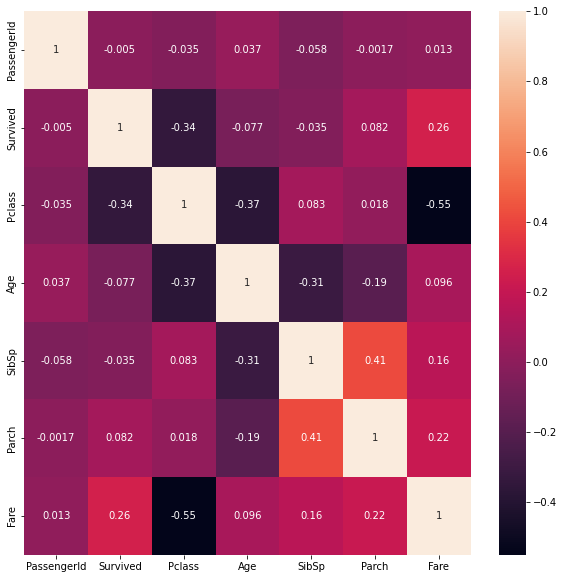

In [6]:
corr = train.corr(method ='pearson')
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, ax=ax)

<AxesSubplot:>

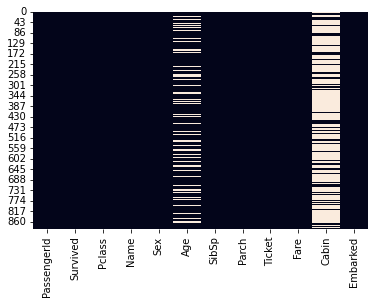

In [7]:
sns.heatmap(train.isnull(), cbar=False)

# Imputing age as per statistics

<AxesSubplot:>

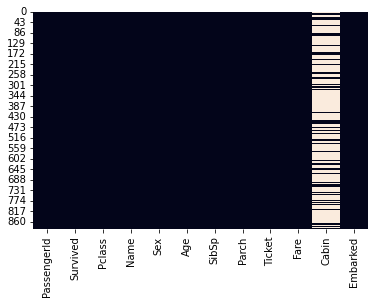

In [8]:
train['Age'] = train['Age'].fillna(train.groupby(['Survived','Pclass','Sex'])['Age'].transform('mean'))
sns.heatmap(train.isnull(), cbar=False)

<AxesSubplot:>

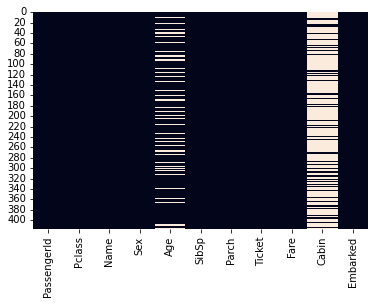

In [9]:
sns.heatmap(test.isnull(), cbar=False)

<AxesSubplot:>

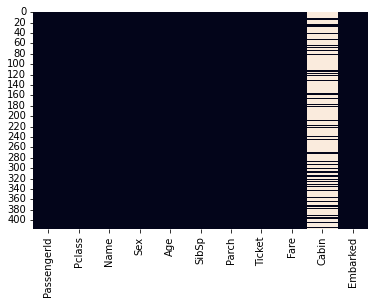

In [10]:
test['Age'] = test['Age'].fillna(train.groupby(['Pclass','Sex'])['Age'].transform('mean'))
sns.heatmap(test.isnull(), cbar=False)

# Droping unnecessary clumns from both dataset

In [11]:
train.drop(['Cabin'], axis = 1, inplace=True)
train.drop(['Ticket'], axis = 1, inplace=True)
train.drop(['Name'], axis = 1, inplace=True)
train.drop(['PassengerId'], axis = 1, inplace=True)
test.drop(['Cabin'], axis = 1, inplace=True)
test.drop(['Ticket'], axis = 1, inplace=True)
test.drop(['Name'], axis = 1, inplace=True)
test_Id  = test.PassengerId
test.drop(['PassengerId'], axis = 1, inplace=True)

# Mode of Embarked column(to impute training data-set)

In [12]:
train.Embarked.mode()

0    S
dtype: object

In [13]:
# train[train.isnull().any(axis=1)] # to check row with NaN value
train['Embarked'].fillna('S', inplace=True) # imputing with 'S'

# Fare of passanger based on Pclass(For imputing on testing data)

In [14]:
train.groupby(['Pclass']).agg({'Fare':'mean'})

,Fare
Pclass,
1,84.154687
2,20.662183
3,13.675550


In [15]:
# test[test.isnull().any(axis=1)] # to check row with NaN value
test['Fare'].fillna(13.675, inplace=True) # imputing with '13.675'

# Changing sex from text to number

In [16]:
train['Sex'].replace({'male':1, 'female':0}, inplace=True)
test['Sex'].replace({'male':1, 'female':0}, inplace=True)

# One hot encoding for Embarked column

In [17]:
# training data
one_hot_embarked = pd.get_dummies(train['Embarked'], drop_first=True)
train = train.drop('Embarked',axis = 1)
train = train.join(one_hot_embarked)
one_hot_embarked.head()
# testing data
one_hot_embarked = pd.get_dummies(test['Embarked'], drop_first=True)
test = test.drop('Embarked',axis = 1)
test = test.join(one_hot_embarked)
one_hot_embarked.head()

,Q,S
0,1,0
1,0,1
2,1,0
3,0,1
4,0,1


# Removing survived column

In [18]:
y = train['Survived']
X = train.drop(['Survived'], axis = 1)

# Data alignment

In [19]:
X, test = X.align(test, join='left', axis=1)

# Data splitting

In [20]:
x_train, x_val, y_train, y_val = train_test_split(X, y, random_state=20, test_size=0.20)

# Data pre-processing is done
Training Data
* **x_train**
* **x_val**
* **y_train**
* **y_val**

Submission Data
* **test**

In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rf = RandomForestRegressor(n_estimators = 500, random_state = 0, max_depth=2)
rf.fit(x_train, y_train)

y_predict = rf.predict(x_val)
mean_squared_error(y_val,y_predict)

0.134597930197311

# Submission

In [22]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


# 100% Data usage before prediction

In [23]:
rf.fit(X, y)
submission_pred = rf.predict(test).round().astype(int)

In [24]:
output = pd.DataFrame({'PassengerId': test_Id, 'Survived': submission_pred})
output.to_csv('submission.csv', index=False)